In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 設定設備（GPU 或 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# 定義 Autoencoder 模型
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),  # 把 28x28 影像展平成 784 維向量
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),  # 壓縮到 latent_dim 維度
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # 確保輸出範圍在 [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon.view(-1, 1, 28, 28)  # 轉回 28x28 影像格式

In [20]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvAutoencoder, self).__init__()

        # **Encoder（編碼器）：使用卷積層**
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 輸入: (1, 28, 28) -> (16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # (16, 14, 14) -> (32, 7, 7)
            nn.BatchNorm2d(32),  # 加入 Batch Normalization
            nn.ReLU(),
            nn.Flatten(),  # 攤平成一維
            nn.Linear(32 * 7 * 7, latent_dim)  # 壓縮到 latent_dim
        )

        # **Decoder（解碼器）：使用轉置卷積層（ConvTranspose2d）**
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),  # 恢復空間結構
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # (32,7,7) -> (16,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16,14,14) -> (1,28,28)
            nn.Sigmoid()  # 確保輸出值在 0~1 之間
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
#  訓練函數
def train_autoencoder(model, train_loader, num_epochs=10):
    model.to(device)
    criterion = nn.MSELoss()  # 使用 MSE 作為損失函數
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)  # 計算 MSE 誤差

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


In [22]:
#  計算誤差（MSE 和 L1）
def evaluate_autoencoder(model, data_loader):
    model.to(device)
    model.eval()
    
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    
    total_mse, total_l1 = 0, 0
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            
            total_mse += mse_loss(outputs, images).item()
            total_l1 += l1_loss(outputs, images).item()
    
    avg_mse = total_mse / len(data_loader)
    avg_l1 = total_l1 / len(data_loader)
    
    return avg_mse, avg_l1

In [23]:
# 顯示重建影像（4x4 網格）
def show_reconstructed_images(model, data_loader, num_images=16):
    model.to(device)
    model.eval()
    
    images, _ = next(iter(data_loader))  # 取一批數據
    images = images[:num_images].to(device)
    
    with torch.no_grad():
        outputs = model(images)

    # 轉換為 numpy 格式
    images = images.cpu().numpy().squeeze()
    outputs = outputs.cpu().numpy().squeeze()

        # 顯示原始影像
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(images[i * 4 + j], cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle("Original Images")
    plt.show()

    # 顯示重建影像
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(outputs[i * 4 + j], cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle("Reconstructed Images")
    plt.show()

In [24]:
# 下載並載入 MNIST 數據集
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


Training Autoencoder with latent dimension = 64
Epoch [1/20], Loss: 0.0427
Epoch [2/20], Loss: 0.0163
Epoch [3/20], Loss: 0.0119
Epoch [4/20], Loss: 0.0097
Epoch [5/20], Loss: 0.0084
Epoch [6/20], Loss: 0.0076
Epoch [7/20], Loss: 0.0070
Epoch [8/20], Loss: 0.0066
Epoch [9/20], Loss: 0.0062
Epoch [10/20], Loss: 0.0059
Epoch [11/20], Loss: 0.0056
Epoch [12/20], Loss: 0.0055
Epoch [13/20], Loss: 0.0053
Epoch [14/20], Loss: 0.0051
Epoch [15/20], Loss: 0.0050
Epoch [16/20], Loss: 0.0049
Epoch [17/20], Loss: 0.0048
Epoch [18/20], Loss: 0.0047
Epoch [19/20], Loss: 0.0046
Epoch [20/20], Loss: 0.0046
Training MSE: 0.0045, L1 Loss: 0.0214
Testing  MSE: 0.0046, L1 Loss: 0.0213
Training Images Reconstruction:


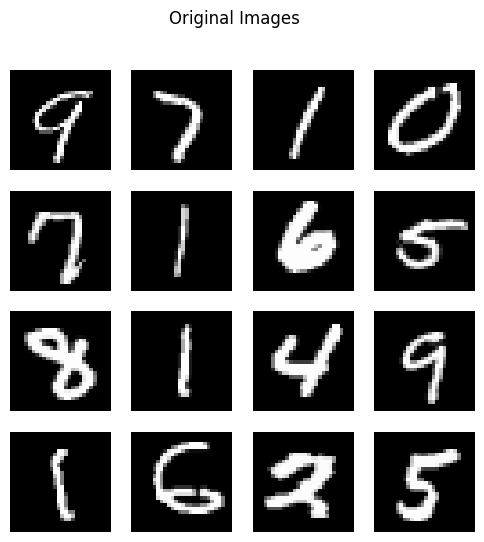

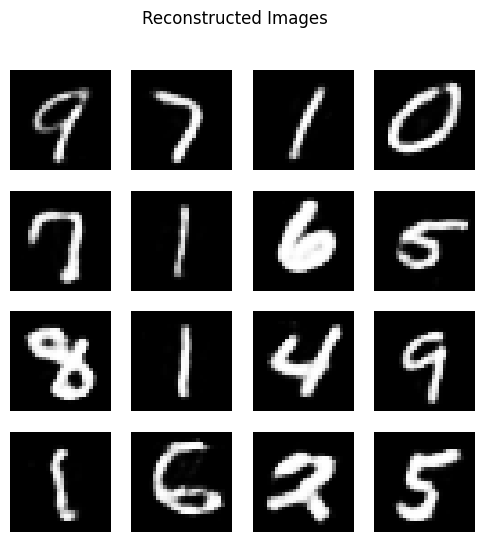

Testing Images Reconstruction:


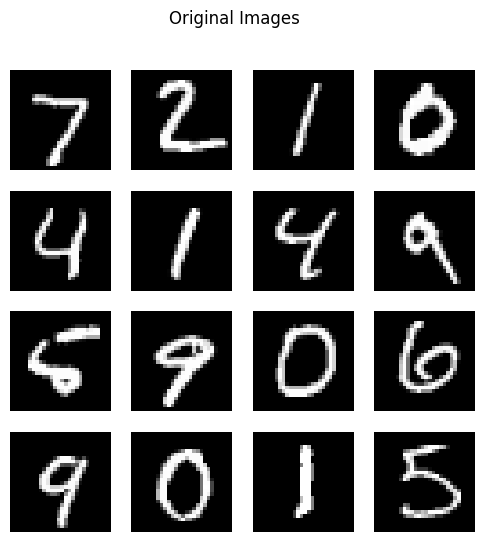

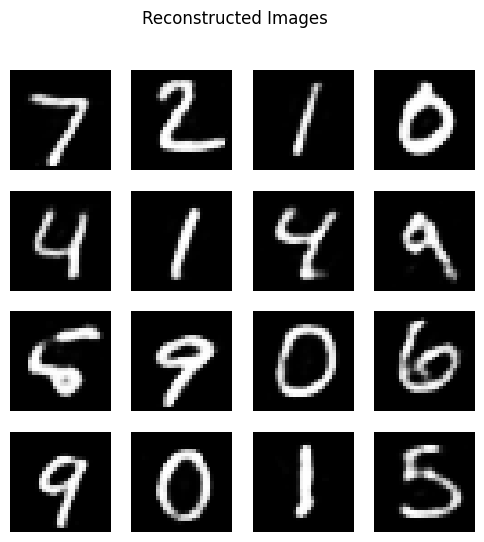


Training Autoencoder with latent dimension = 32
Epoch [1/20], Loss: 0.0435
Epoch [2/20], Loss: 0.0193
Epoch [3/20], Loss: 0.0159
Epoch [4/20], Loss: 0.0143
Epoch [5/20], Loss: 0.0133
Epoch [6/20], Loss: 0.0126
Epoch [7/20], Loss: 0.0120
Epoch [8/20], Loss: 0.0116
Epoch [9/20], Loss: 0.0112
Epoch [10/20], Loss: 0.0109
Epoch [11/20], Loss: 0.0107
Epoch [12/20], Loss: 0.0104
Epoch [13/20], Loss: 0.0102
Epoch [14/20], Loss: 0.0100
Epoch [15/20], Loss: 0.0099
Epoch [16/20], Loss: 0.0097
Epoch [17/20], Loss: 0.0096
Epoch [18/20], Loss: 0.0095
Epoch [19/20], Loss: 0.0094
Epoch [20/20], Loss: 0.0093
Training MSE: 0.0091, L1 Loss: 0.0318
Testing  MSE: 0.0093, L1 Loss: 0.0317
Training Images Reconstruction:


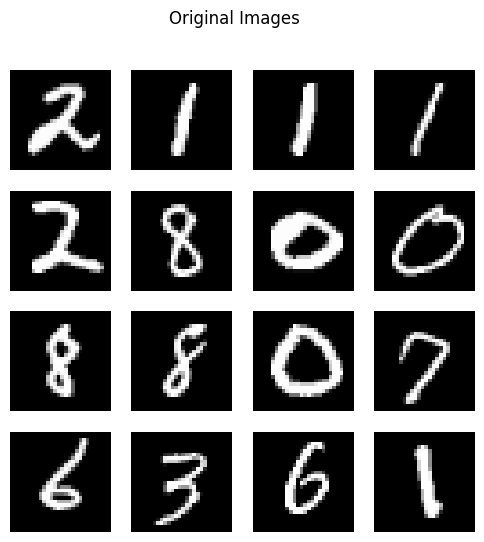

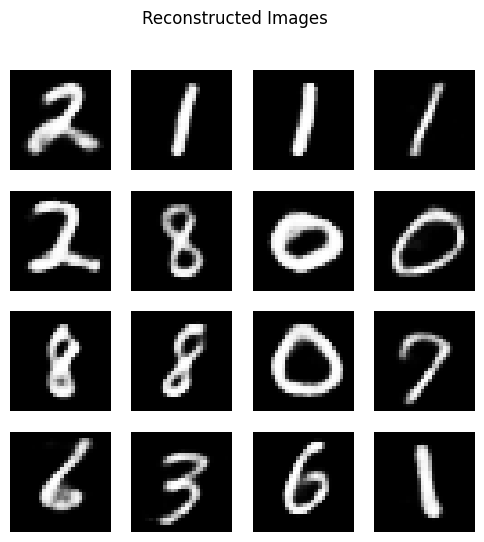

Testing Images Reconstruction:


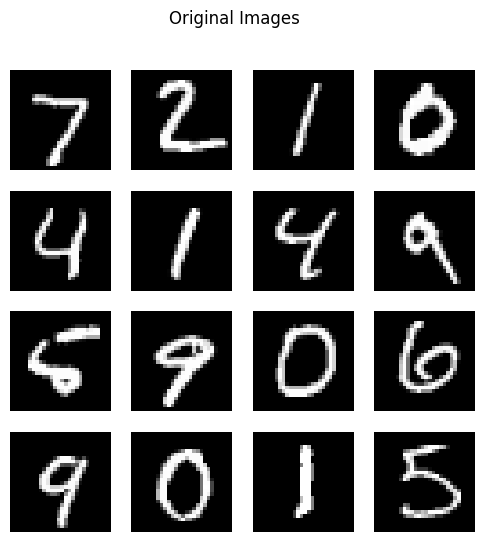

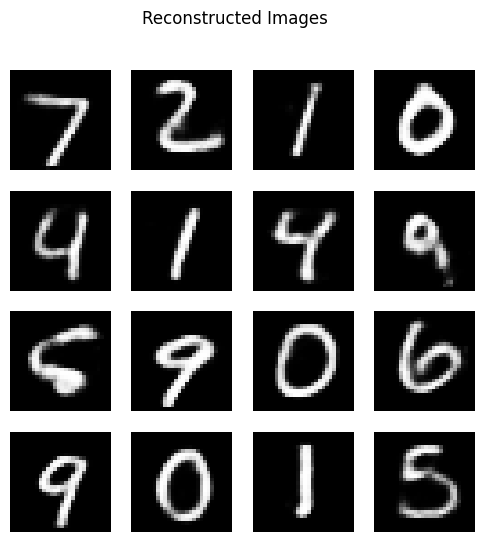


Training Autoencoder with latent dimension = 4
Epoch [1/20], Loss: 0.0673
Epoch [2/20], Loss: 0.0612
Epoch [3/20], Loss: 0.0599
Epoch [4/20], Loss: 0.0584
Epoch [5/20], Loss: 0.0575
Epoch [6/20], Loss: 0.0569
Epoch [7/20], Loss: 0.0562
Epoch [8/20], Loss: 0.0558
Epoch [9/20], Loss: 0.0553
Epoch [10/20], Loss: 0.0549
Epoch [11/20], Loss: 0.0546
Epoch [12/20], Loss: 0.0543
Epoch [13/20], Loss: 0.0539
Epoch [14/20], Loss: 0.0535
Epoch [15/20], Loss: 0.0532
Epoch [16/20], Loss: 0.0529
Epoch [17/20], Loss: 0.0526
Epoch [18/20], Loss: 0.0492
Epoch [19/20], Loss: 0.0464
Epoch [20/20], Loss: 0.0457
Training MSE: 0.0454, L1 Loss: 0.1064
Testing  MSE: 0.0458, L1 Loss: 0.1070
Training Images Reconstruction:


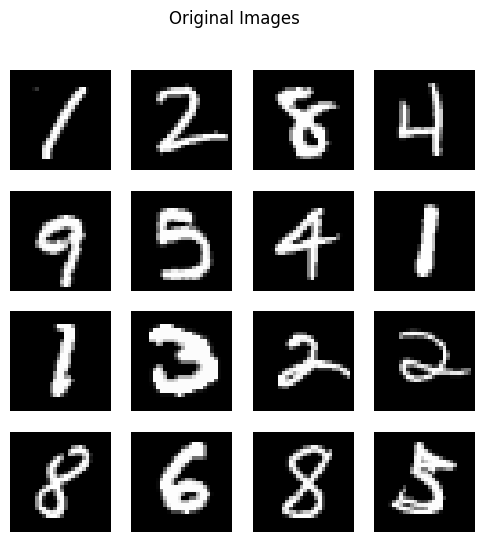

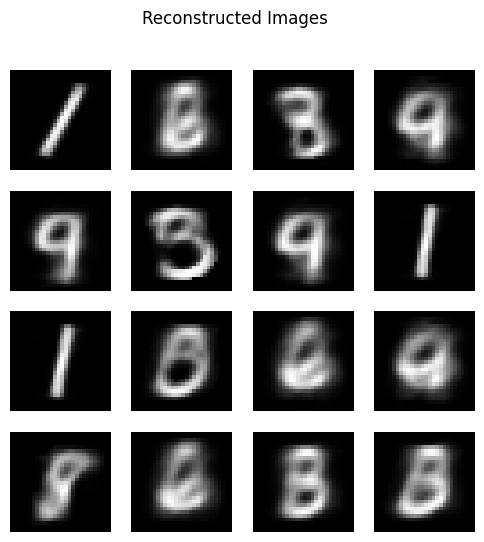

Testing Images Reconstruction:


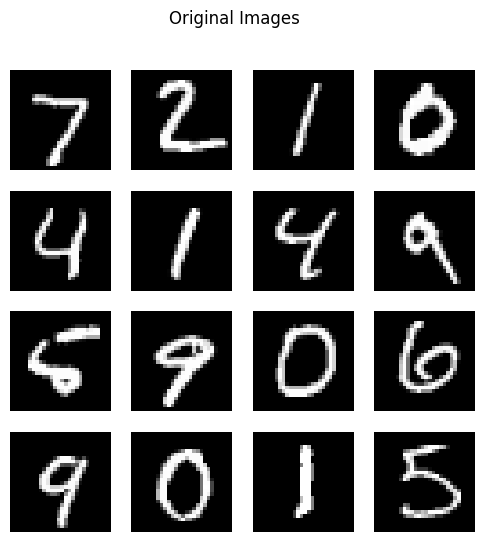

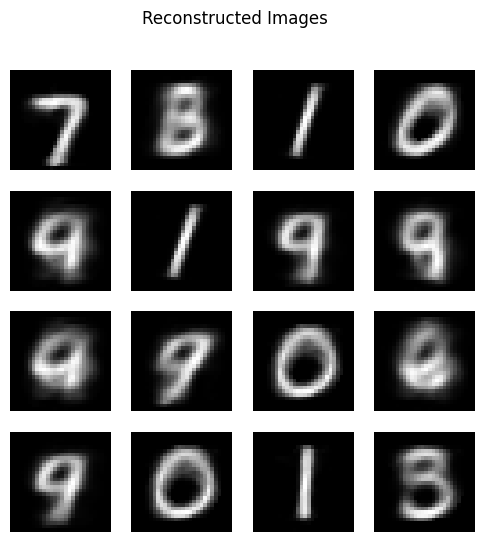

In [25]:
#  訓練並評估 Autoencoder（測試不同 latent_dim）
latent_dims = [64, 32, 4]

for latent_dim in latent_dims:
    print(f"\nTraining Autoencoder with latent dimension = {latent_dim}")
    autoencoder = Autoencoder(latent_dim)
    train_autoencoder(autoencoder, train_loader, num_epochs=20)

    train_mse, train_l1 = evaluate_autoencoder(autoencoder, train_loader)
    test_mse, test_l1 = evaluate_autoencoder(autoencoder, test_loader)

    print(f"Training MSE: {train_mse:.4f}, L1 Loss: {train_l1:.4f}")
    print(f"Testing  MSE: {test_mse:.4f}, L1 Loss: {test_l1:.4f}")

    # 顯示重建影像
    print("Training Images Reconstruction:")
    show_reconstructed_images(autoencoder, train_loader)

    print("Testing Images Reconstruction:")
    show_reconstructed_images(autoencoder, test_loader)

In [26]:
# 下載並載入 FashionMNIST 數據集
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


Training Autoencoder with latent dimension = 64
Epoch [1/20], Loss: 0.0330
Epoch [2/20], Loss: 0.0170
Epoch [3/20], Loss: 0.0145
Epoch [4/20], Loss: 0.0130
Epoch [5/20], Loss: 0.0121
Epoch [6/20], Loss: 0.0113
Epoch [7/20], Loss: 0.0107
Epoch [8/20], Loss: 0.0102
Epoch [9/20], Loss: 0.0098
Epoch [10/20], Loss: 0.0095
Epoch [11/20], Loss: 0.0092
Epoch [12/20], Loss: 0.0090
Epoch [13/20], Loss: 0.0088
Epoch [14/20], Loss: 0.0086
Epoch [15/20], Loss: 0.0085
Epoch [16/20], Loss: 0.0083
Epoch [17/20], Loss: 0.0082
Epoch [18/20], Loss: 0.0081
Epoch [19/20], Loss: 0.0080
Epoch [20/20], Loss: 0.0079
Training MSE: 0.0078, L1 Loss: 0.0466
Testing  MSE: 0.0081, L1 Loss: 0.0474
Training Images Reconstruction:


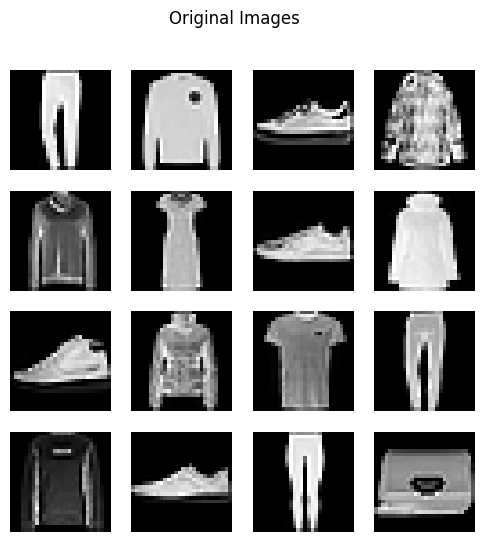

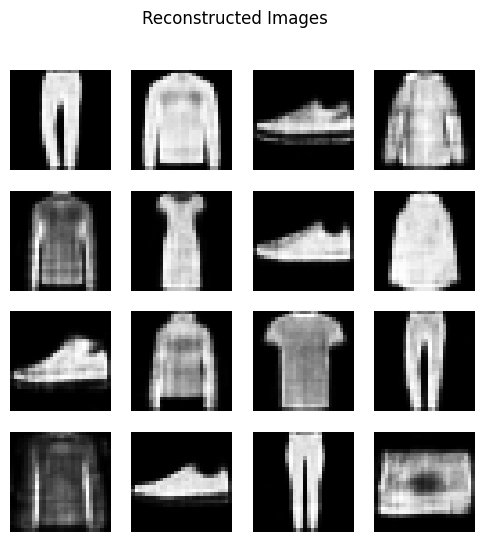

Testing Images Reconstruction:


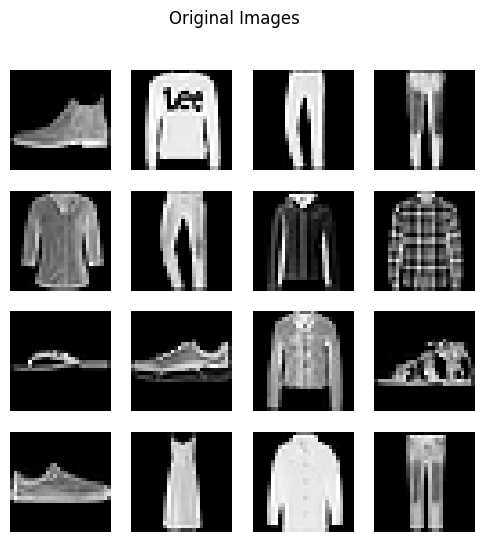

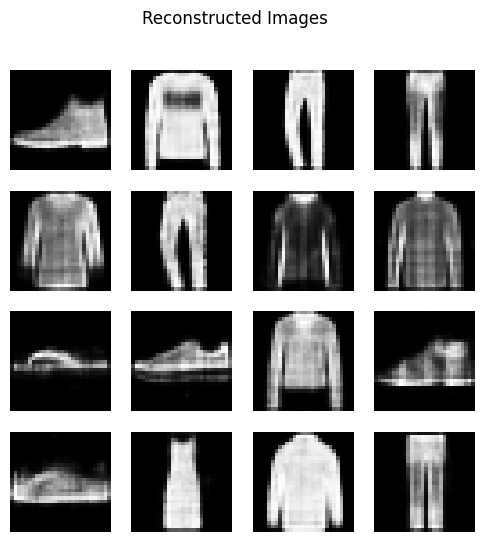


Training Autoencoder with latent dimension = 32
Epoch [1/20], Loss: 0.0338
Epoch [2/20], Loss: 0.0178
Epoch [3/20], Loss: 0.0154
Epoch [4/20], Loss: 0.0142
Epoch [5/20], Loss: 0.0134
Epoch [6/20], Loss: 0.0128
Epoch [7/20], Loss: 0.0123
Epoch [8/20], Loss: 0.0120
Epoch [9/20], Loss: 0.0118
Epoch [10/20], Loss: 0.0115
Epoch [11/20], Loss: 0.0114
Epoch [12/20], Loss: 0.0112
Epoch [13/20], Loss: 0.0111
Epoch [14/20], Loss: 0.0110
Epoch [15/20], Loss: 0.0109
Epoch [16/20], Loss: 0.0108
Epoch [17/20], Loss: 0.0107
Epoch [18/20], Loss: 0.0107
Epoch [19/20], Loss: 0.0106
Epoch [20/20], Loss: 0.0106
Training MSE: 0.0105, L1 Loss: 0.0536
Testing  MSE: 0.0108, L1 Loss: 0.0545
Training Images Reconstruction:


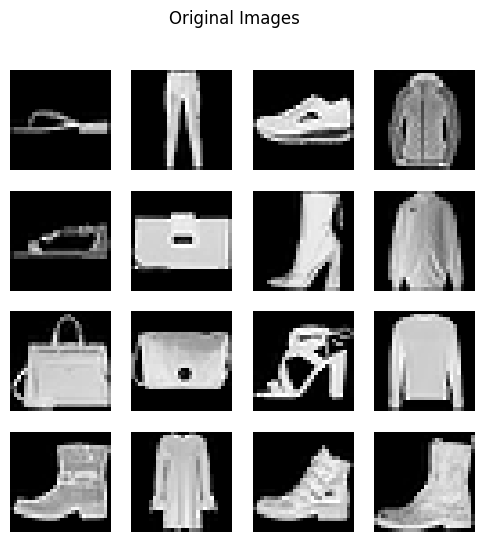

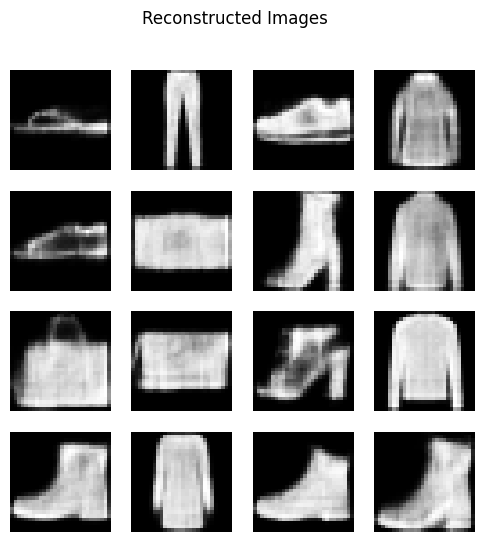

Testing Images Reconstruction:


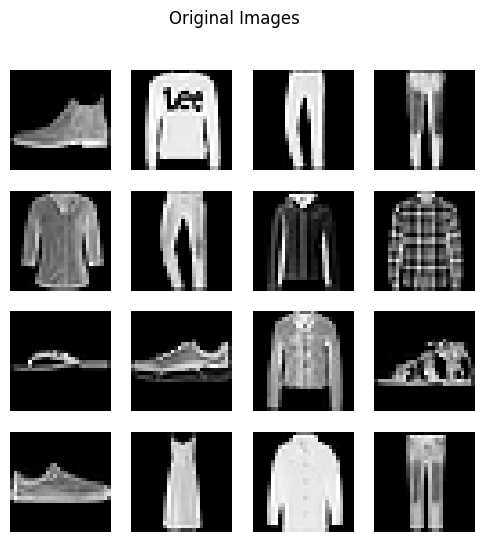

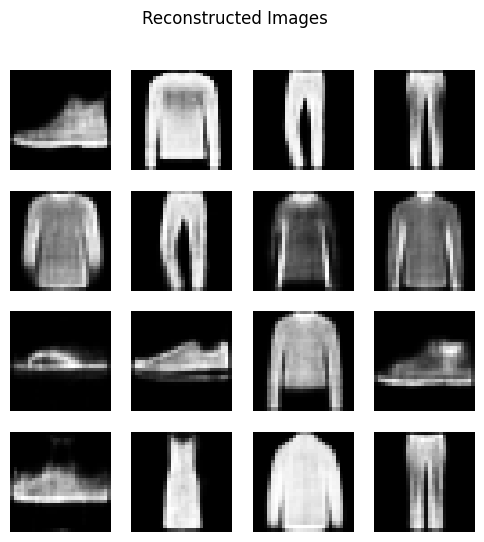


Training Autoencoder with latent dimension = 4
Epoch [1/20], Loss: 0.0504
Epoch [2/20], Loss: 0.0250
Epoch [3/20], Loss: 0.0230
Epoch [4/20], Loss: 0.0221
Epoch [5/20], Loss: 0.0215
Epoch [6/20], Loss: 0.0212
Epoch [7/20], Loss: 0.0209
Epoch [8/20], Loss: 0.0207
Epoch [9/20], Loss: 0.0205
Epoch [10/20], Loss: 0.0204
Epoch [11/20], Loss: 0.0202
Epoch [12/20], Loss: 0.0201
Epoch [13/20], Loss: 0.0200
Epoch [14/20], Loss: 0.0199
Epoch [15/20], Loss: 0.0198
Epoch [16/20], Loss: 0.0198
Epoch [17/20], Loss: 0.0197
Epoch [18/20], Loss: 0.0196
Epoch [19/20], Loss: 0.0196
Epoch [20/20], Loss: 0.0195
Training MSE: 0.0194, L1 Loss: 0.0747
Testing  MSE: 0.0198, L1 Loss: 0.0757
Training Images Reconstruction:


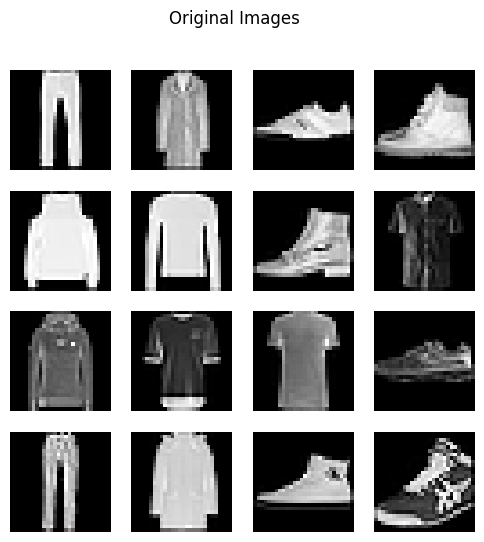

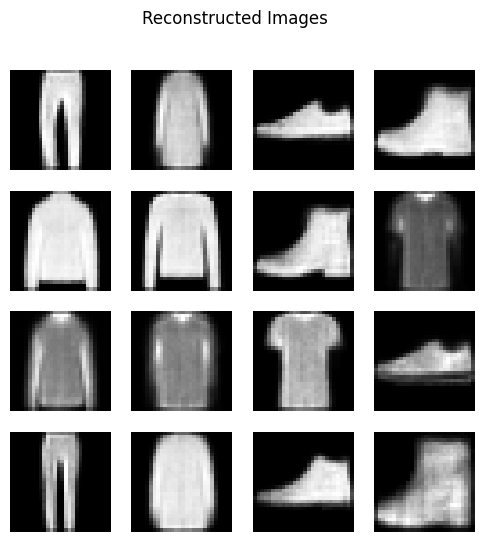

Testing Images Reconstruction:


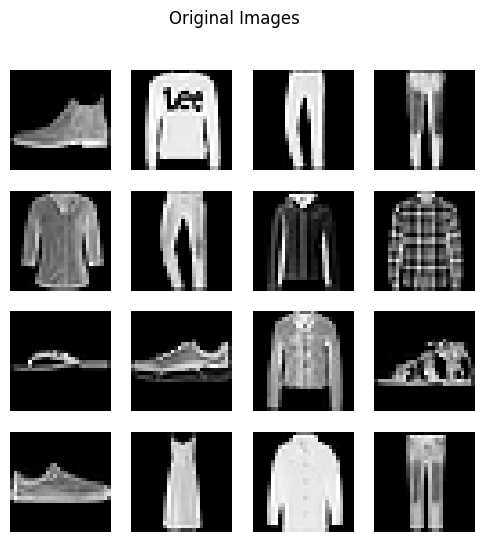

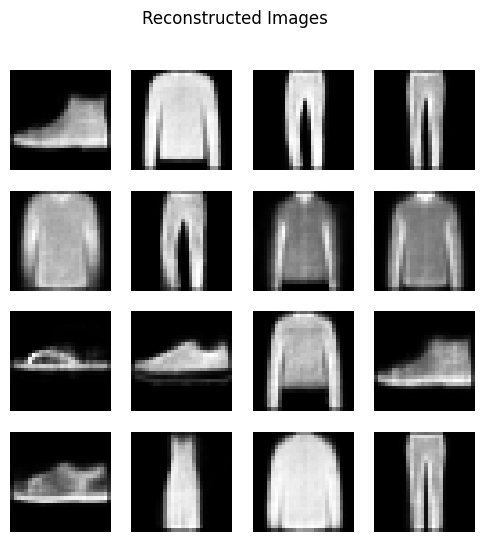

In [27]:
#  訓練並評估 Autoencoder（測試不同 latent_dim）
latent_dims = [64, 32, 4]

for latent_dim in latent_dims:
    print(f"\nTraining Autoencoder with latent dimension = {latent_dim}")
    autoencoder = Autoencoder(latent_dim)
    train_autoencoder(autoencoder, train_loader, num_epochs=20)

    train_mse, train_l1 = evaluate_autoencoder(autoencoder, train_loader)
    test_mse, test_l1 = evaluate_autoencoder(autoencoder, test_loader)

    print(f"Training MSE: {train_mse:.4f}, L1 Loss: {train_l1:.4f}")
    print(f"Testing  MSE: {test_mse:.4f}, L1 Loss: {test_l1:.4f}")

    # 顯示重建影像
    print("Training Images Reconstruction:")
    show_reconstructed_images(autoencoder, train_loader)

    print("Testing Images Reconstruction:")
    show_reconstructed_images(autoencoder, test_loader)